## Imports and Constants

In [25]:
import cv2
import json
import math
import numpy as np
import os
import pyproj
import requests
import threading
from matplotlib import pyplot as plt
from osgeo import gdal, ogr, osr

WA_SOUTH_EPSG = 'EPSG:2927'
WGS84_EPSG = 'EPSG:4326' # This is the projection system for Mercator and Map Tiles


## Getting map tiles from State Plane feet coordinates

#### This X/Y is in State Plane Feet for the Space Needle in Seattle

In [26]:
XY_SEATTLE = (1_184_355.269, 839_450.242)

### Finding the closest map tile to our XY_SEATTLE Coordinate

#### Transform the state plane coordinates to WGS84 lat/lon

In [27]:
# First transform the XY coordinate to LAT/LONG using pyproj (Proj4)
# Create Transformer object from crs (coordinate reference systems)
# Argument 1 is the coordinate system to be inputed
# Argument 2 is the coordinate system to be transformed into

transformer = pyproj.Transformer.from_crs(WA_SOUTH_EPSG, WGS84_EPSG)
lat, lon = transformer.transform(*XY_SEATTLE)
lat, lon

(47.62047833051376, -122.34925913830723)

#### This algorithm comes from Open Street Map https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames

In [28]:
# Use the algorithm from OpenStreetMap to convert Lat/Long to closest Map Tile at a given zoom level
# For this example we will use Zoom Level 18

zoom_level = 18
n = 2 ** zoom_level

# Convert Lat from degrees to radians
lat_rad = math.radians(lat)

# Get X tile number from Longitude Degrees
xtile = int((lon + 180.0) / 360.0 * n)

# Get Y tile number from Latitude Radians
ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
print('Without TMS (X,Y) -\t', (xtile, ytile))

# If using Tile Map Serivces (TMS) style of tiling, the Y tile number needs to be corrected for TMS
ytile_TMS = n - ytile - 1
print('With TMS (X,Y) -\t', (xtile, ytile_TMS))

Without TMS (X,Y) -	 (41979, 91536)
With TMS (X,Y) -	 (41979, 170607)


#### Get closest map tile from OpenStreetMap

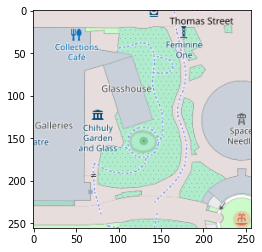

In [29]:
# This is the base url for OpenStreetMap tiles
# Format with Zoom Level, X tile number and Y tile number to get the tile
base_url = 'https://tile.openstreetmap.org/{zoom}/{x}/{y}.png'

# Request the tile usings requests
req = requests.get(base_url.format(zoom=zoom_level, x=xtile, y=ytile))

# Write req.content to a temp file on disk, the content will be in bytes so enable 'wb' in open(...)
tempfile = f'temp_tile_{zoom_level}_{xtile}_{ytile}.png'
with open(tempfile, 'wb') as f:
    f.write(req.content)

# Read the temp file to a numpy array using OpenCV
image = cv2.imread(tempfile)

# Now that it is a numpy array, delete the temp file
os.remove(tempfile)

plt.imshow(image)

#### Get multiple map tiles around the target tile 

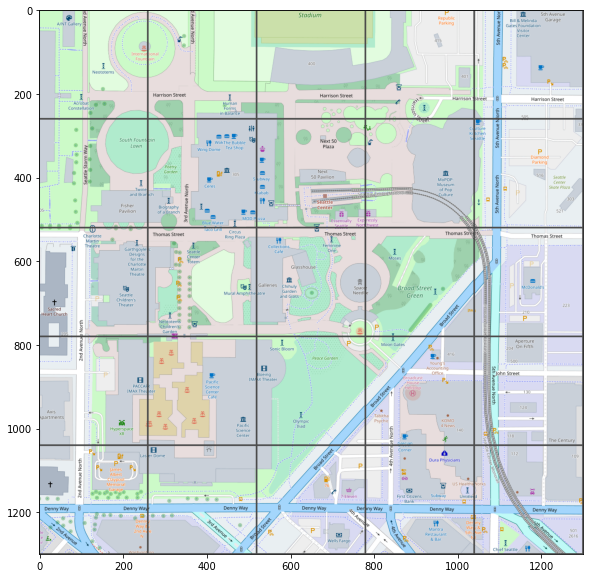

In [35]:
# Using a number of to expand on either side, we can get a range of X and Y tile numbers surrounding the target tile
offset = 2
xtile_rng = range(xtile - offset, xtile + offset + 1)
ytile_rng = range(ytile - offset, ytile + offset + 1)

# Using a for-loop we can get the numpy arrays of the map tile images as we did above
# Then using OpenCV we can concatenate the images into a master image
horizontal_concat = []
for x in xtile_rng:
    vertical_concat = []
    for y in ytile_rng:
        # Requesting and writing the image as above
        req = requests.get(base_url.format(zoom=zoom_level, x=x, y=y))
        tempfile = f'temp_tile_{zoom_level}_{x}_{y}.png'
        with open(tempfile, 'wb') as f:
            f.write(req.content)
        image = cv2.imread(tempfile)
        os.remove(tempfile)
        
        # Adding a border to each image to see the individual tiles in the master image
        image = cv2.copyMakeBorder(image, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=(75, 75, 75))
        
        # Adding the image (numpy array) to the vertical_concat list
        vertical_concat.append(image)
    
    # Vertically concatenating the arrays in the vertical_concat list and adding that concatenated image array to the
    # horizontal_concat list
    vertical_image = cv2.vconcat(vertical_concat)
    horizontal_concat.append(vertical_image)

# Horizontally concatenating the vertical images to create the master image array
master_image = cv2.hconcat(horizontal_concat)

# Make matplotlib chart bigger 
plt.rcParams['figure.figsize'] = [10, 10]

plt.imshow(master_image)

## Georeferencing the tile image and exporting to PDF or TIFF

#### Getting Ground Control Points
Using the map tile number we can convert to Lat/Lon of the Northwest (upper-left) Corner of each tile

This algorithm also comes from OpenStreetMap https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames

In [36]:
min_xtile = min(xtile_rng)
min_ytile = min(ytile_rng)

ground_control_pts = []
for x in xtile_rng:
    for y in ytile_rng:
        # Convert tile numbers to lat/lon
        lon = x / n * 360.0 - 180.0  # degrees
        lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * y / n)))  # radians
        lat = math.degrees(lat_rad)  # degrees
        
        # Using the min tiles and current tiles to get the pixel index of the master image array
        # Each tile is 256 x 256 pixels
        xtile_idx = float((x - min_xtile) * 256)
        ytile_idx = float((y - min_ytile) * 256)
        
        # Using GDAL to create ground control points and adding them to the ground_control_pts list
        # gdal.GCP takes 5 arguments: longitude, latitude, z-value, x-value, y-value
        gcp = gdal.GCP(lon, lat, 0.0, xtile_idx, ytile_idx)
        ground_control_pts.append(gcp)
        
ground_control_pts       

[<osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B46B79FE0> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B46B7BF00> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B46B7BF30> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B46B79170> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B46B79C20> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B46FCB8A0> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B46B11F80> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B470A1980> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B46B94360> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B46B943F0> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x0000017B46B94480> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of 

#### Converting the master image to GDAL raster in memory and exporting to georeferenced PDF or GeoTIFF

In [38]:
# gdal.Driver.Create creates a raster datatset and needs these 4 arguments: 
# filename (empty string for in-memory rasters), raster width, raster height, number of bands
dataset = gdal.GetDriverByName('MEM').Create('', master_image.shape[1], master_image.shape[0], master_image.shape[2])

# Writing the master image array to the raster object
# When using a numpy array the interleave needs to be 'pixel'
# If using a numpy array from OpenCV, the bands list needs to be reversed because OpenCV is BGR (blue-green-red)
# instead of normal RGB (red-green-blue)
dataset.WriteArray(master_image, interleave='pixel', band_list=[3, 2, 1])

# Create a Spatial Reference and import it from the WGS84 EPSG number
srs = osr.SpatialReference()
srs.ImportFromEPSG(int(WGS84_EPSG.split(':')[1]))

# Set the projection and spatial ref for the dataset
dataset.SetProjection(srs.ExportToWkt())
dataset.SetSpatialRef(srs)

# Setting the ground control points for the dataset
dataset.SetGCPs(ground_control_pts , dataset.GetProjection())


# The dataset needs to be "warped" to finish the georeferencing
# Setting the warp options
warp_options = gdal.WarpOptions(
    format='MEM', 
    width=master_image.shape[1], 
    height=master_image.shape[0], 
    srcSRS=WGS84_EPSG, 
    dstSRS=WGS84_EPSG
)
# Warping the dataset to a new in-memory dataset
warp = gdal.Warp('', dataset, options=warp_options)

# Set the driver to "PDF" for georeferenced PDFs or "GTiff" for GeoTIFF
filename = 'seattle_georeferenced.pdf'   # OR 'seattle_georeferenced.tiff'
driver = gdal.GetDriverByName('PDF')  # OR gdal.GetDriverByName('GTiff')

# Create a copy of the warped dataset which will write the new file to disk
driver.CreateCopy(filename, warp, 1)

# Need to "let-go" of the datasets to be able to write to disk
dataset = None
warp = None

#### You now have a georeferenced PDF or TIFF from using state plane coordinates